In [1]:
import os
os.chdir("..")

In [2]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score

/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from PCA import PCA

In [4]:
from preprocessing import DataLoader, DataProcessor
from clustering.kmeans import kmeans, global_kmeans
from clustering.optics import optics

In [5]:
data_loader = DataLoader()
data_processor = DataProcessor()

datasets_info = {
        'satimage': data_loader.load_arff_data('satimage'),
        'splice': data_loader.load_arff_data('splice'),
        'vowel': data_loader.load_arff_data('vowel')
    }

preprocessed_datasets = {}
for dataset_name, (df, labels) in datasets_info.items():
    preprocessed_df = data_processor.preprocess_dataset(df)
    
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    preprocessed_datasets[dataset_name] = {
        'df': preprocessed_df,
        'labels': encoded_labels
    }

### Utils to plot

In [6]:
# UMAP
def plot_2d(df, labels, title, axis=True):
    sns.set_style('white')

    # Create a single plot for UMAP with n_neighbors set to 15 in 2D
    fig = plt.figure(figsize=(8, 6))  # Adjust figure size

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(df, columns=['UMAP Dim 1', 'UMAP Dim 2'])
    plot_df['Cluster'] = labels.astype(int)  # Convert to integers for proper numerical sorting

    # Ensure the legend is ordered numerically
    plot_df['Cluster'] = pd.Categorical(plot_df['Cluster'], categories=sorted(plot_df['Cluster'].unique()), ordered=True)

    # Create a 2D scatter plot
    ax = fig.add_subplot(111)
    scatter = ax.scatter(plot_df['UMAP Dim 1'], plot_df['UMAP Dim 2'],
                        c=plot_df['Cluster'], cmap='tab10', s=10, alpha=0.8)
    
    if axis:
        legend = ax.legend(*scatter.legend_elements(),
                        title="Clusters",
                        loc="best")
        ax.add_artist(legend)

    # Add title and labels
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('UMAP Dim 1')
    ax.set_ylabel('UMAP Dim 2')

    # Adjust the layout to leave room for the title
    plt.tight_layout()
    plt.show()

# Original Data

### PCA

Selected top 8 eigenvectors to reach at least 85.0% (reached 86.00%) cumulative explained variance.



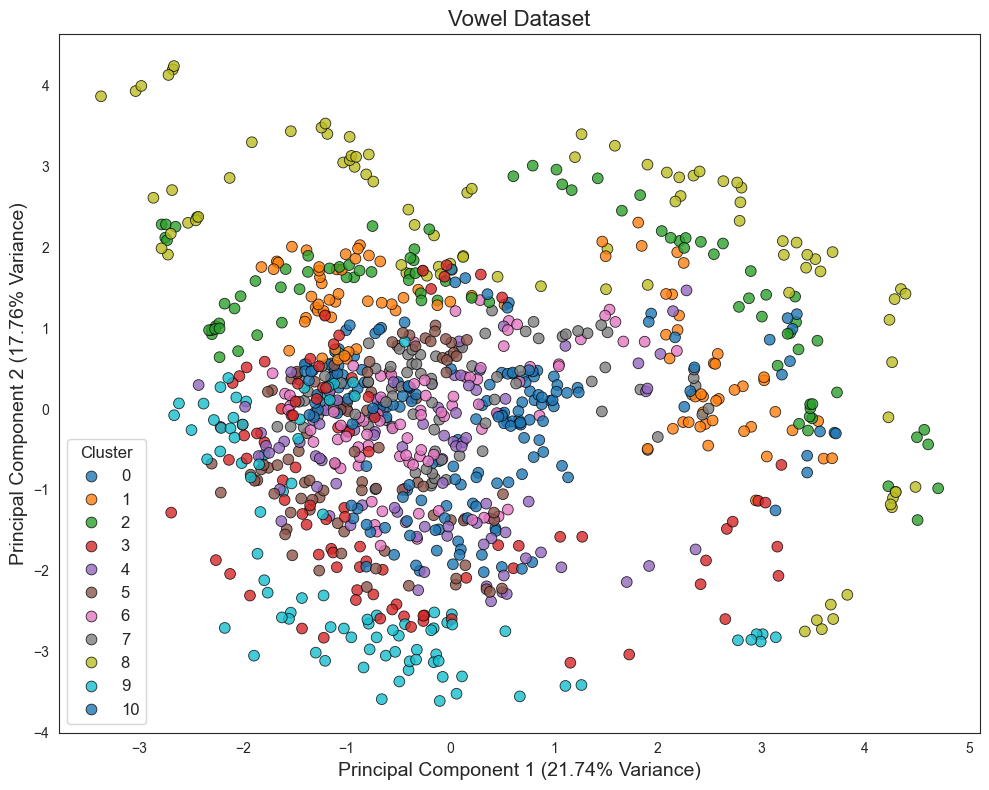

In [14]:
for dataset_name, dataset_content in preprocessed_datasets.items():
    data = dataset_content['df']
    labels = np.array(dataset_content['labels']).astype(int)

    if dataset_name == "vowel":
        reducer = PCA.imlPCA()
        reduced_data = reducer.fit_transform(data)
        reducer.plot_pca_subspace(reduced_data, labels, dataset_name[0].upper()+dataset_name[1:])
    

### UMAP

In [7]:
def plot_umap_2d(df, labels, title, axis=True):
    sns.set_style('white')

    # Create a single plot for UMAP with n_neighbors set to 15 in 2D
    fig = plt.figure(figsize=(8, 6))  # Adjust figure size

    # Compute UMAP embedding
    n_neighbors = 15
    um = umap.UMAP(n_neighbors=n_neighbors, min_dist=0.1, n_components=2, random_state=0)
    embedding = um.fit_transform(df)

    plot_2d(embedding, labels, title, axis)

/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<Figure size 800x600 with 0 Axes>

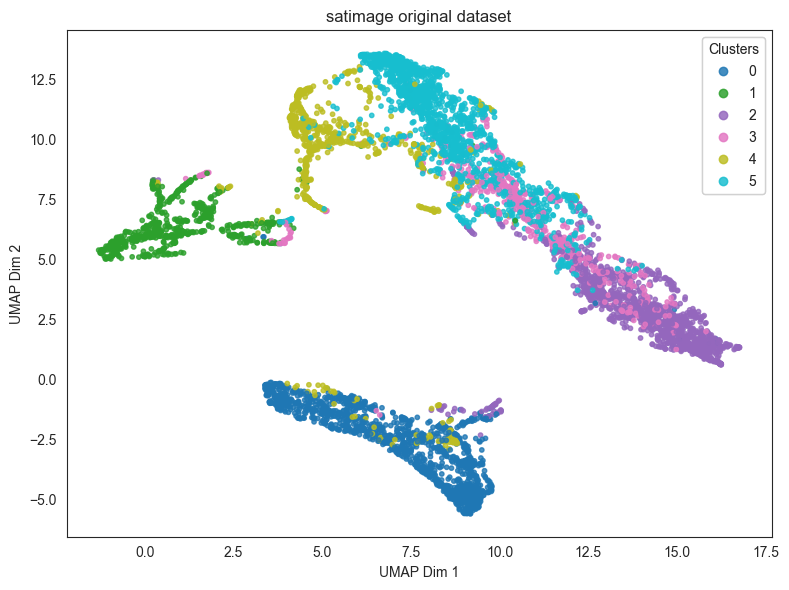

/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Figure size 800x600 with 0 Axes>

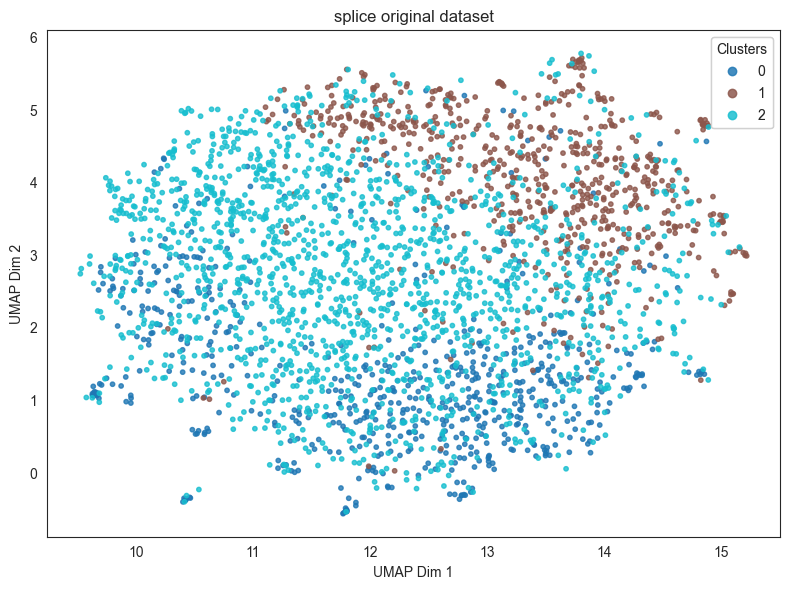

/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Figure size 800x600 with 0 Axes>

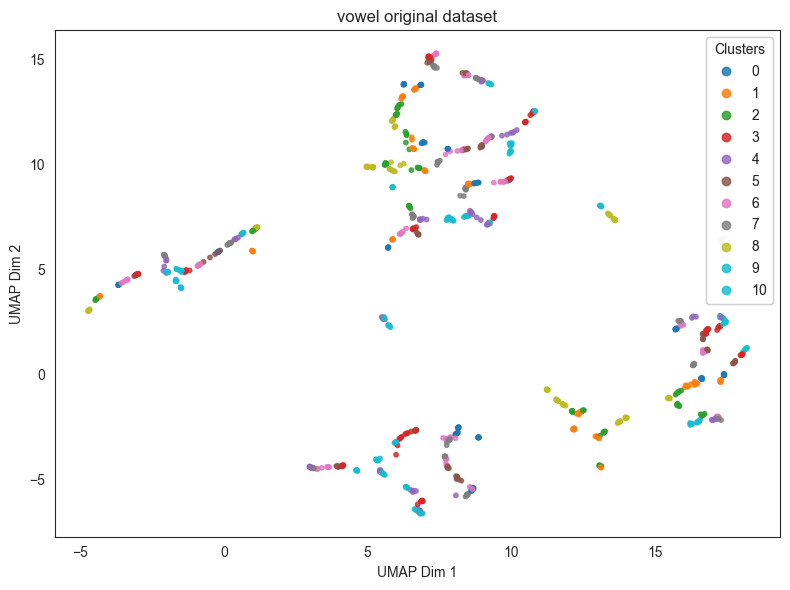

In [8]:
for dataset_name, dataset_content in preprocessed_datasets.items():
    df = np.array(dataset_content['df'])
    labels = np.array(dataset_content['labels']).astype(int)

    plot_umap_2d(df, labels, f"{dataset_name} original dataset")

# Clustering

## KMeans

In [10]:
def compute_kmeans(data, k, distance, seed):
    km = kmeans.KMeans(k=k, distance=distance, seed=seed)
    return km.fit_predict(data) 

### UMAP

satimage got ARI score = 0.5799574847801042


/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Figure size 800x600 with 0 Axes>

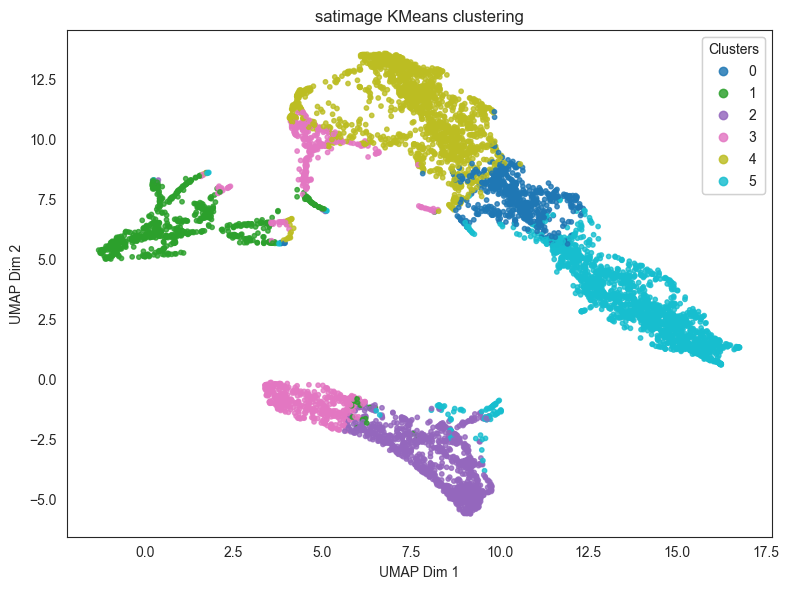

splice got ARI score = 0.4240088015139832


/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Figure size 800x600 with 0 Axes>

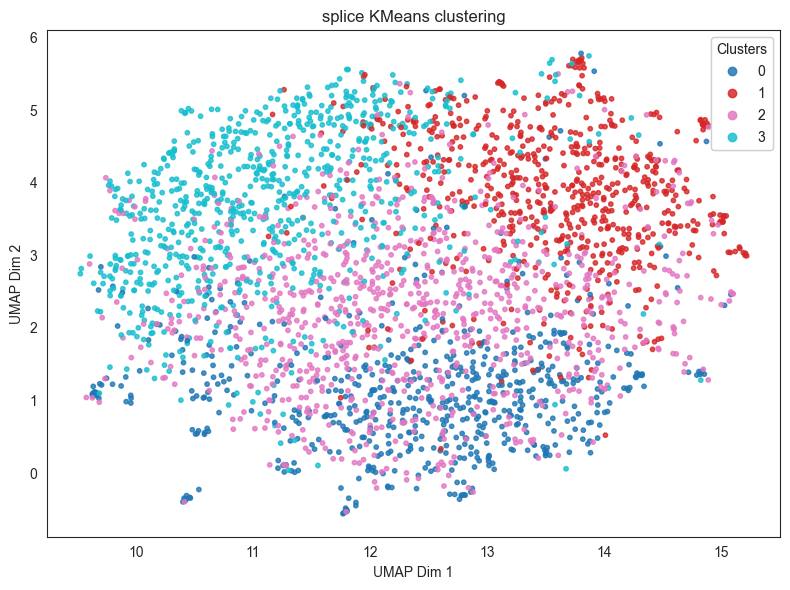

vowel got ARI score = 0.1272089397347837


/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Figure size 800x600 with 0 Axes>

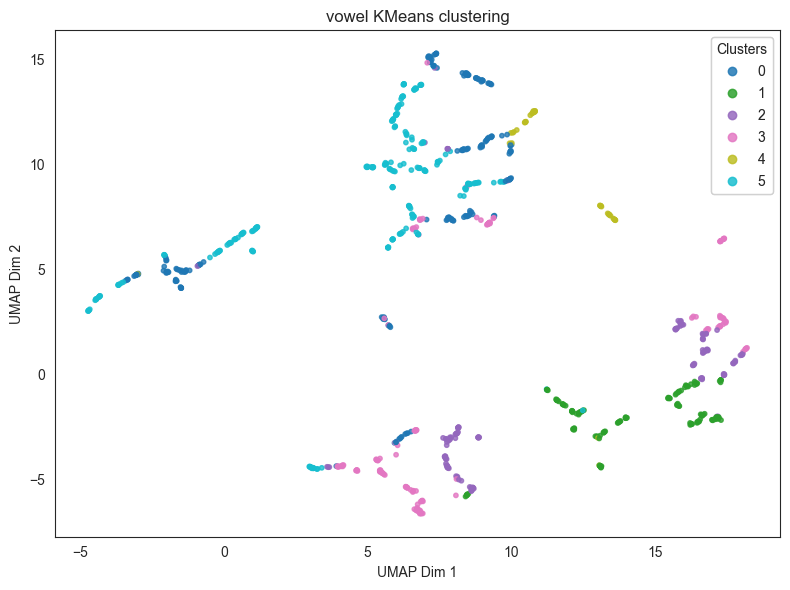

In [12]:
seeds = [0, 1, 2, 3, 4]
for dataset_name, dataset_content in preprocessed_datasets.items():
    data = dataset_content['df']
    labels = np.array(dataset_content['labels']).astype(int)

    max_ari = -1
    best_pred = None

    for seed in seeds:
        if dataset_name == 'satimage':
            y_pred = compute_kmeans(data, 6, 'cosine', seed)
        elif dataset_name == 'splice':
            y_pred = compute_kmeans(data, 4, 'euclidean', seed)
        else:
            y_pred = compute_kmeans(data, 6, 'euclidean', seed)

        ari_score = adjusted_rand_score(labels, y_pred)

        if ari_score > max_ari:
            max_ari = ari_score
            best_pred = y_pred

    
    print(f"{dataset_name} got ARI score = {ari_score}")

    # reducer = umap.UMAP(n_components=3, random_state=42)
    # reduced_data = reducer.fit_transform(data)

    plot_umap_2d(data, y_pred, f"{dataset_name} KMeans clustering")

### PCA

Selected top 2 eigenvectors to reach at least 85.0% (reached 85.23%) cumulative explained variance.



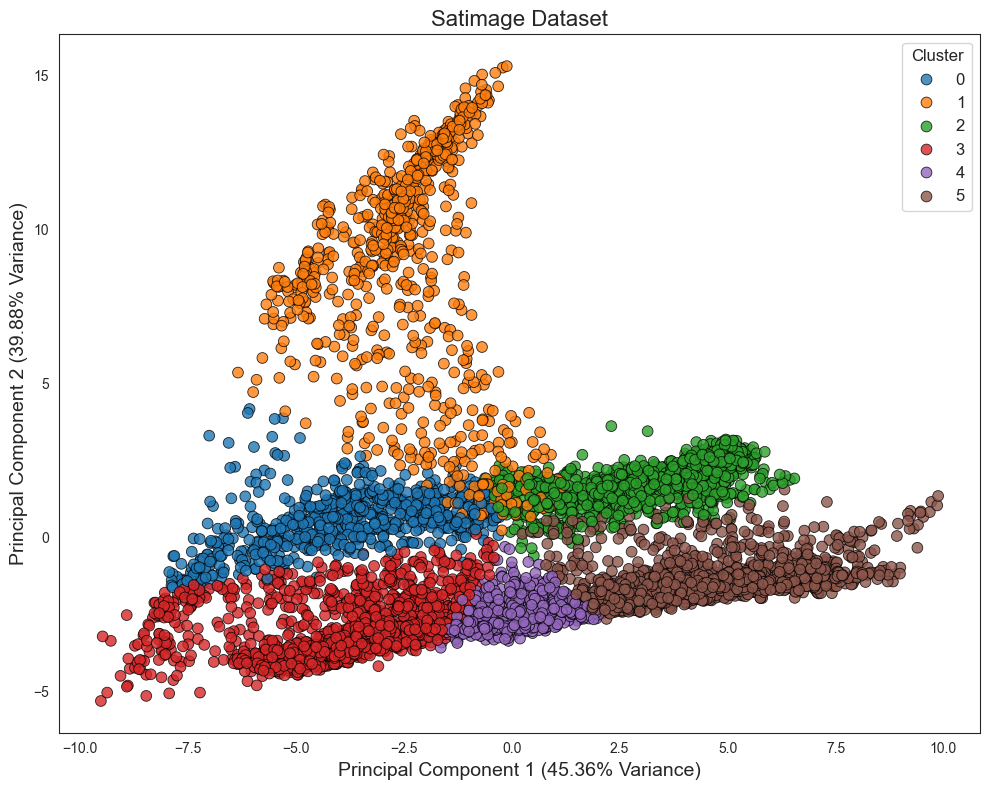

In [ ]:
for dataset_name, dataset_content in preprocessed_datasets.items():
    data = dataset_content['df']

    if dataset_name == 'satimage':
        y_pred = compute_kmeans(data, 6, 'cosine')
    elif dataset_name == 'splice':
        y_pred = compute_kmeans(data, 4, 'euclidean')
    else:
        y_pred = compute_kmeans(data, 6, 'euclidean')

    
    reducer = PCA.imlPCA()
    reduced_data = reducer.fit_transform(data)
    reducer.plot_pca_subspace(reduced_data, y_pred, dataset_name[0].upper()+dataset_name[1:])

## Optics

In [12]:
def compute_optics(data, metric, algorithm, min_samples, n_jobs=1):
    # returns labels from optics
    return optics.opticsAlgorithm(data, metric, algorithm, min_samples, n_jobs)

### UMAP

In [30]:
for dataset_name, dataset_content in preprocessed_datasets.items():
    data = dataset_content['df']
    labels = np.array(dataset_content['labels']).astype(int)

    if dataset_name == 'satimage':
        y_pred = compute_optics(data, "euclidean", "brute", 2)
    elif dataset_name == 'splice':
        y_pred = compute_optics(data, "l1", "brute", 2)
    else:
        y_pred = compute_optics(data, "euclidean", "brute", 4)

    ari_score = adjusted_rand_score(labels, y_pred)
    print(f"{dataset_name} got ARI score = {ari_score}")

    

    # plot_umap_2d(data, y_pred, f"{dataset_name} optics clustering", axis=False)

satimage got ARI score = 0.022078769429878815


/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/sklearn/cluster/_optics.py:1083: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


splice got ARI score = 0.18572145174203333
vowel got ARI score = 0.08887751907924711


### PCA

Selected top 2 eigenvectors to reach at least 85.0% (reached 85.23%) cumulative explained variance.



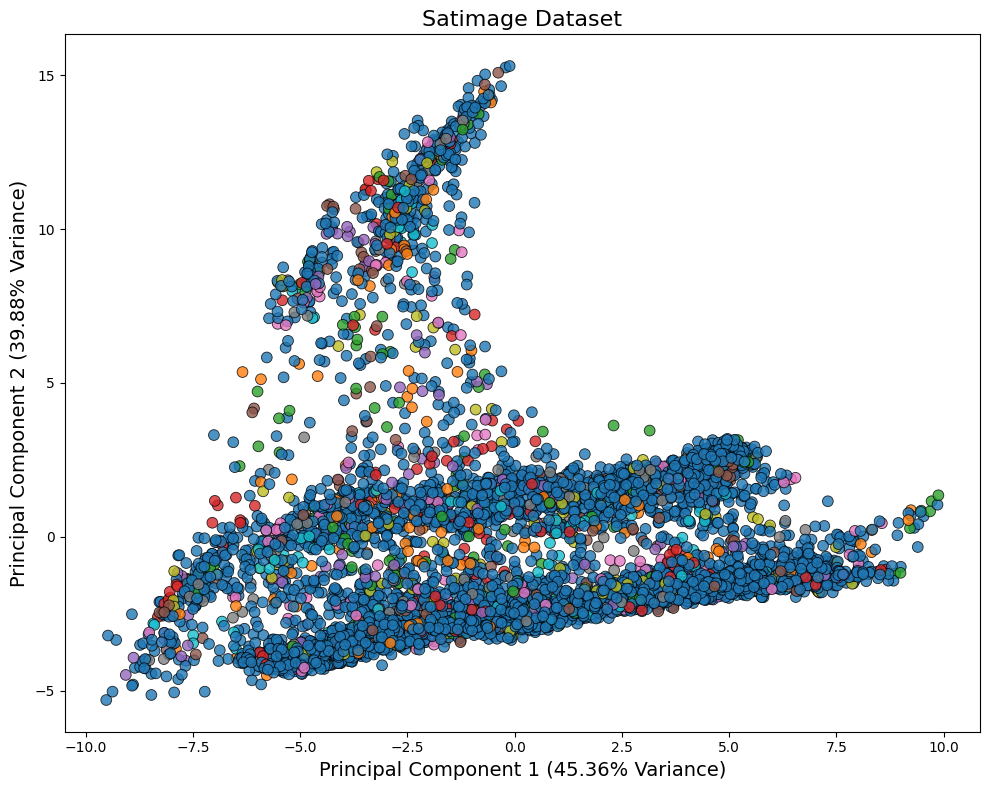

/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/sklearn/cluster/_optics.py:1083: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Selected top 133 eigenvectors to reach at least 85.0% (reached 85.17%) cumulative explained variance.



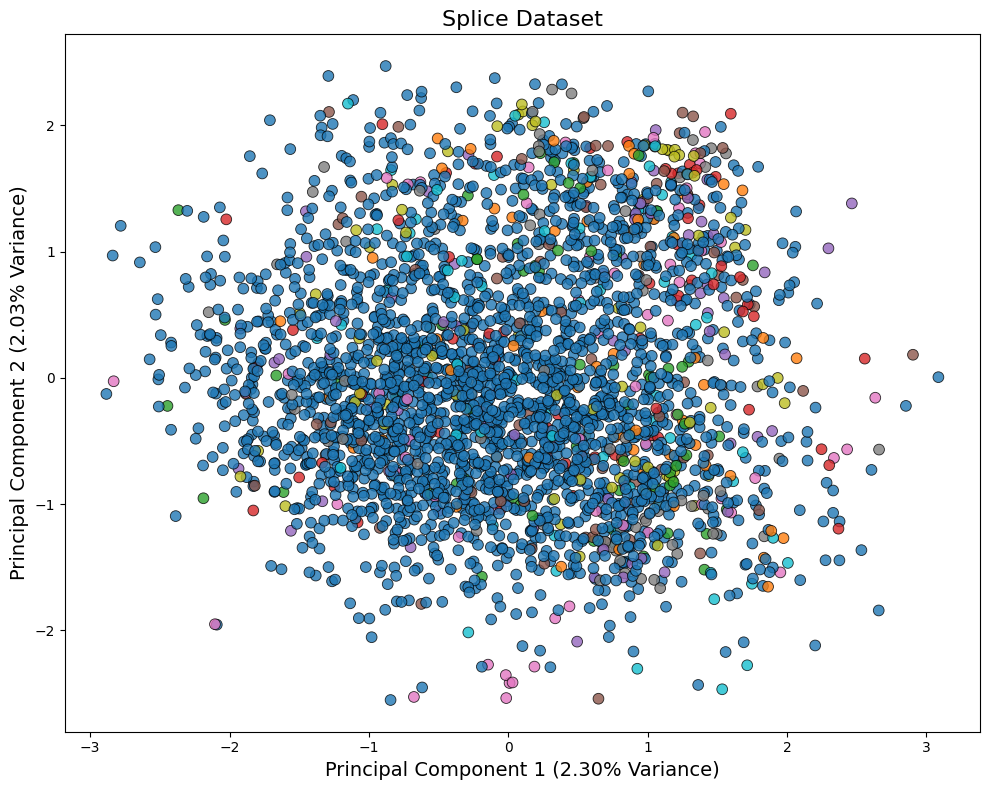

Selected top 8 eigenvectors to reach at least 85.0% (reached 86.00%) cumulative explained variance.



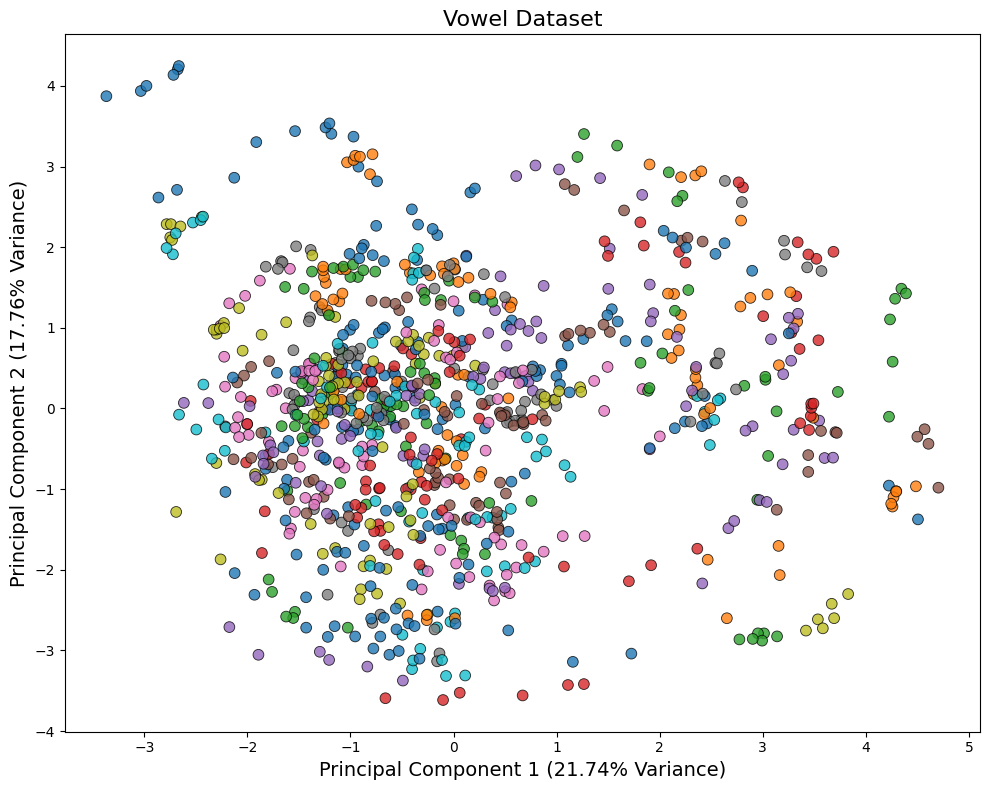

In [8]:
for dataset_name, dataset_content in preprocessed_datasets.items():
    data = dataset_content['df']

    if dataset_name == 'satimage':
        y_pred = compute_optics(data, "euclidean", "brute", 2)
    elif dataset_name == 'splice':
        y_pred = compute_optics(data, "l1", "brute", 2)
    else:
        y_pred = compute_optics(data, "euclidean", "brute", 4)

    reducer = PCA.imlPCA()
    reduced_data = reducer.fit_transform(data)
    reducer.plot_pca_subspace(reduced_data, y_pred, dataset_name[0].upper()+dataset_name[1:], legend=False)

# Reduction + clustering

### UMAP

In [13]:
import time

/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


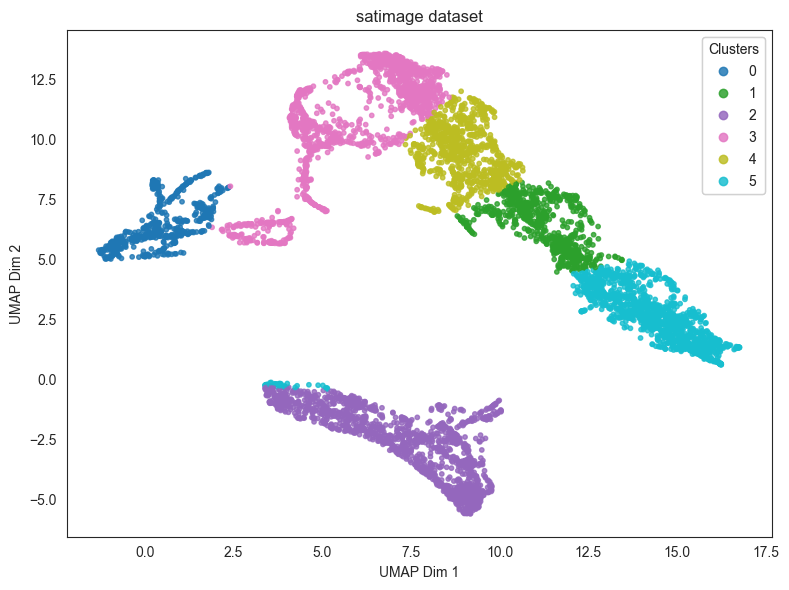

/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


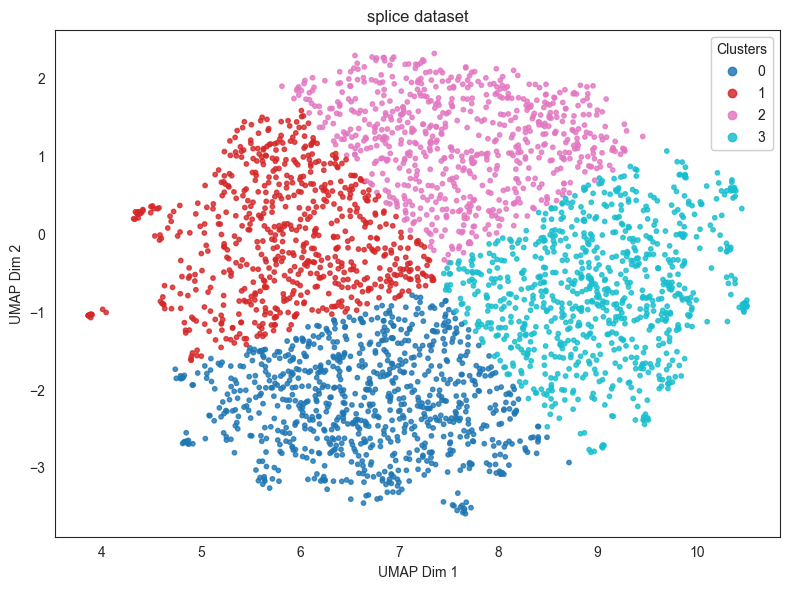

/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


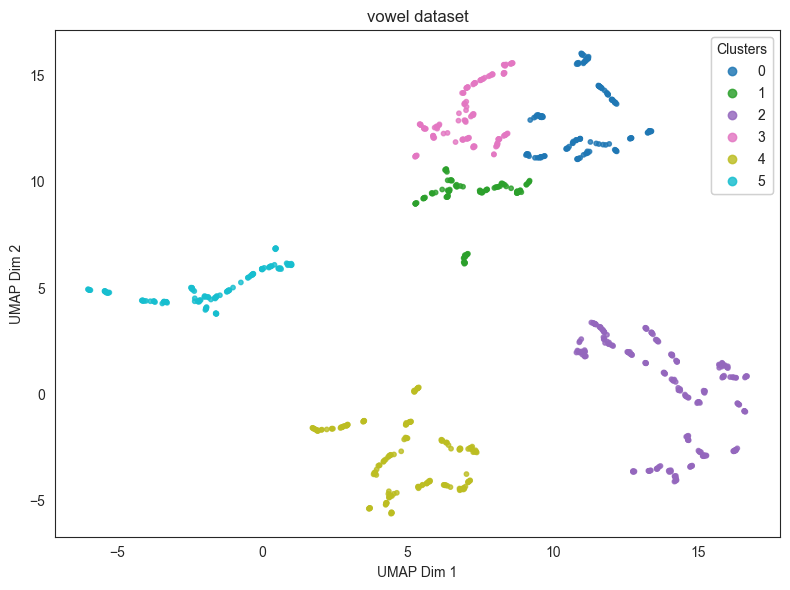

In [ ]:
seeds = [0, 1, 2, 3, 4]
results = []

for dataset_name, dataset_content in preprocessed_datasets.items():
    data = dataset_content['df']
    labels = np.array(dataset_content['labels']).astype(int)

    best_ari_score = -1
    best_reduced_data = None
    best_y_pred = None
    total_time = 0

    for seed in seeds:
        start = time.time()
        reducer = umap.UMAP(n_components=2, random_state=seed)
        reduced_data = reducer.fit_transform(data)
        end = time.time()
        total_time += (end-start)

        if dataset_name == 'satimage':
            y_pred = compute_kmeans(reduced_data, 6, 'cosine')
        elif dataset_name == 'splice':
            y_pred = compute_kmeans(reduced_data, 4, 'euclidean')
        else:
            y_pred = compute_kmeans(reduced_data, 6, 'euclidean')

        ari_score = adjusted_rand_score(labels, y_pred)

        if ari_score > best_ari_score:
            best_ari_score = ari_score
            best_reduced_data = reduced_data
            best_y_pred = y_pred

    mean_time = total_time / len(seeds)
    results.append({
        'dataset': dataset_name,
        'best_ari_score': best_ari_score,
        'mean_time': mean_time
    })

    plot_2d(best_reduced_data, best_y_pred, f"{dataset_name} dataset", axis=True)

results_df = pd.DataFrame(results)
# results_df.to_csv('umap_kmeans.csv', index=False)

/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


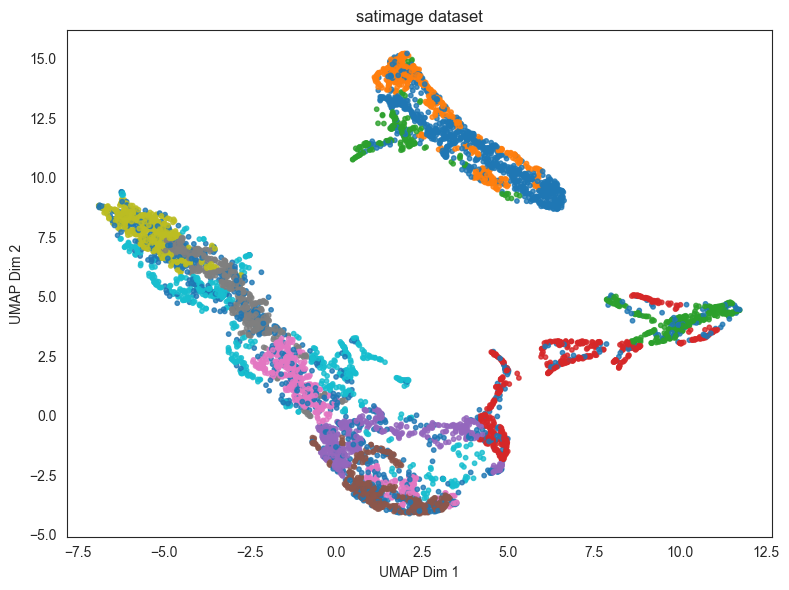

/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


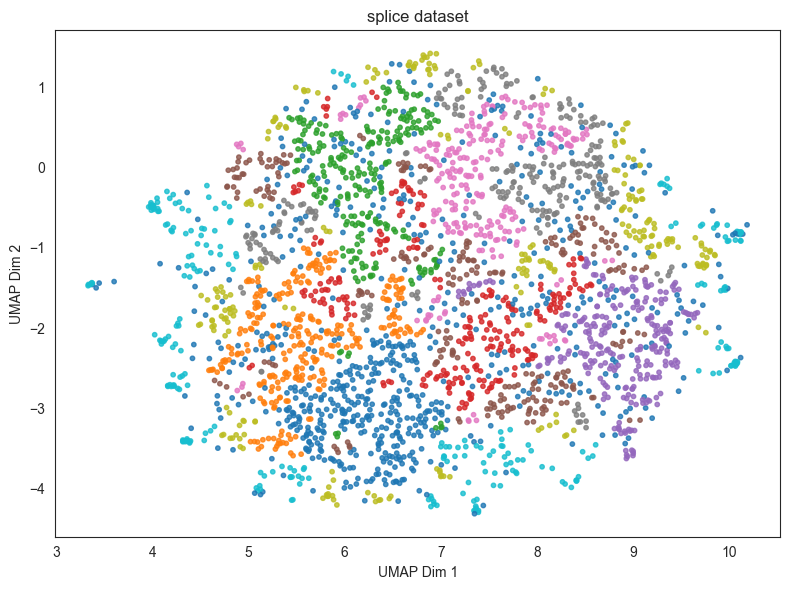

/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


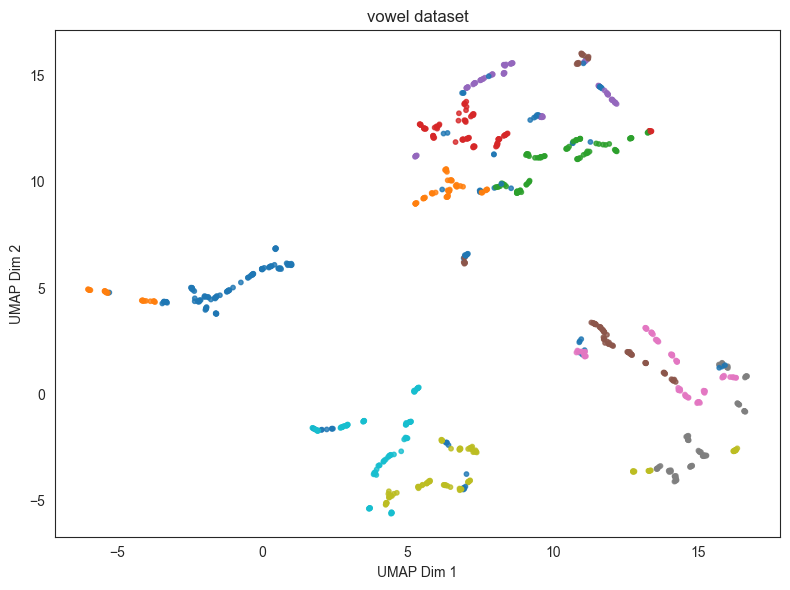

In [16]:
results = []

for dataset_name, dataset_content in preprocessed_datasets.items():
    data = dataset_content['df']
    labels = np.array(dataset_content['labels']).astype(int)

    best_ari_score = -1
    best_reduced_data = None
    best_y_pred = None
    total_time = 0

    for seed in seeds:
        start = time.time()
        reducer = umap.UMAP(n_components=2, random_state=seed)
        reduced_data = reducer.fit_transform(data)
        end = time.time()
        total_time += (end-start)

    if dataset_name == 'satimage':
        y_pred = compute_optics(reduced_data, "euclidean", "brute", 2)
    elif dataset_name == 'splice':
        y_pred = compute_optics(reduced_data, "l1", "brute", 2)
    else:
        y_pred = compute_optics(reduced_data, "euclidean", "brute", 4)

    ari_score = adjusted_rand_score(labels, y_pred)
    
    if ari_score > best_ari_score:
            best_ari_score = ari_score
            best_reduced_data = reduced_data
            best_y_pred = y_pred

    mean_time = total_time / len(seeds)
    results.append({
        'dataset': dataset_name,
        'best_ari_score': best_ari_score,
        'mean_time': mean_time
    })

    plot_2d(best_reduced_data, best_y_pred, f"{dataset_name} dataset", axis=False)

results_df = pd.DataFrame(results)
results_df.to_csv('umap_optics.csv', index=False)

### PCA

Selected top 2 eigenvectors to reach at least 85.0% (reached 85.23%) cumulative explained variance.

satimage took 0.10347390174865723s
satimage got ARI score = 0.5580243312674781


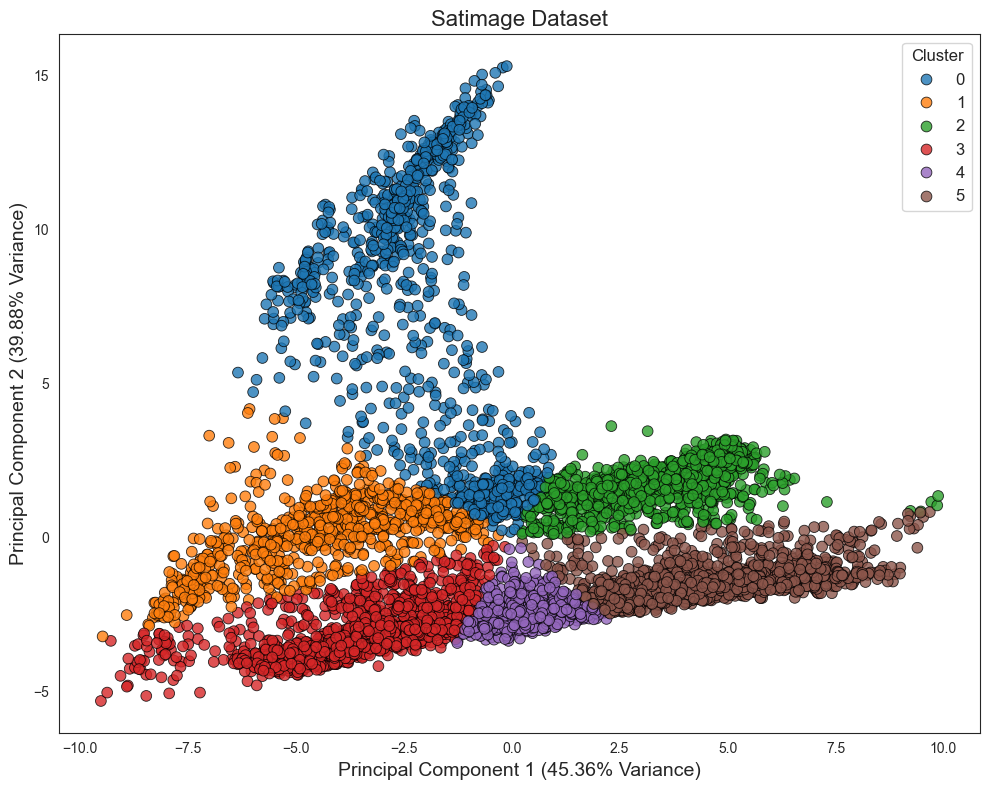

Selected top 133 eigenvectors to reach at least 85.0% (reached 85.17%) cumulative explained variance.

splice took 0.023348093032836914s
splice got ARI score = 0.42700340775581497


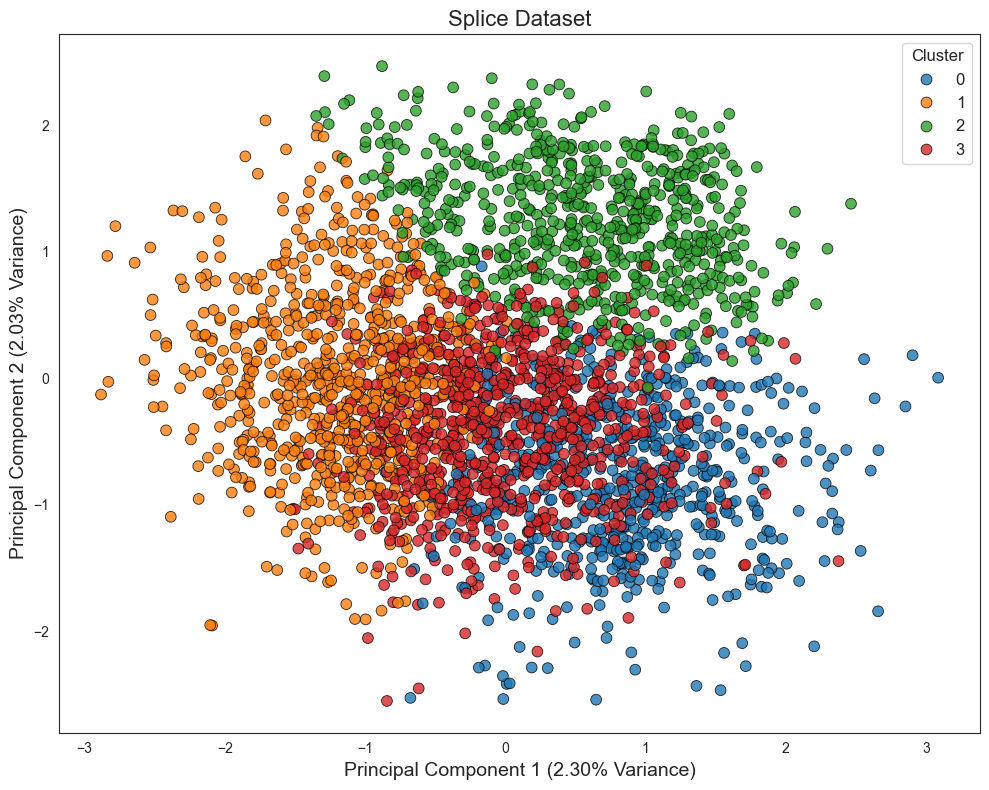

Selected top 8 eigenvectors to reach at least 85.0% (reached 86.00%) cumulative explained variance.

vowel took 0.004358053207397461s
vowel got ARI score = 0.13788985389598973


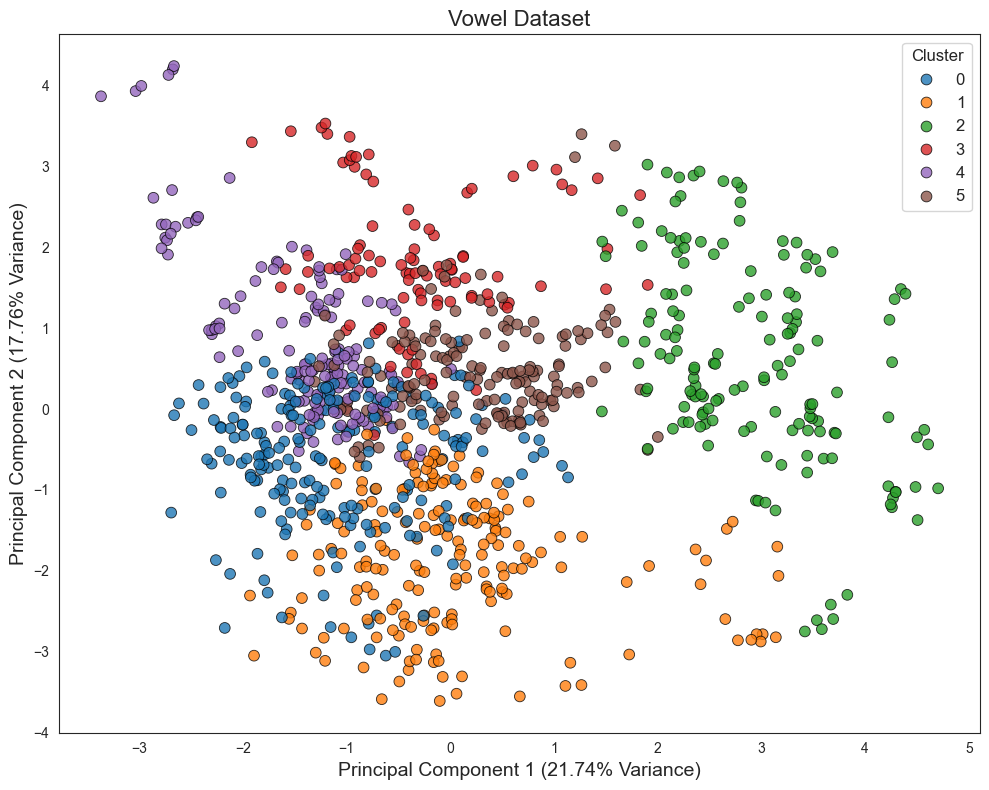

In [19]:
for dataset_name, dataset_content in preprocessed_datasets.items():
    data = dataset_content['df']
    labels = np.array(dataset_content['labels']).astype(int)

    start = time.time()
    reducer = PCA.imlPCA()
    reduced_data = reducer.fit_transform(data)
    end = time.time()
    print(f"{dataset_name} took {end-start}s")

    if dataset_name == 'satimage':
        y_pred = compute_kmeans(reduced_data, 6, 'cosine')
    elif dataset_name == 'splice':
        y_pred = compute_kmeans(reduced_data, 4, 'euclidean')
    else:
        y_pred = compute_kmeans(reduced_data, 6, 'euclidean')

    ari_score = adjusted_rand_score(labels, y_pred)
    print(f"{dataset_name} got ARI score = {ari_score}")

    reducer.plot_pca_subspace(reduced_data, y_pred, dataset_name[0].upper()+dataset_name[1:], legend=True)

Selected top 2 eigenvectors to reach at least 85.0% (reached 85.23%) cumulative explained variance.

satimage took 0.005027055740356445s
satimage got ARI score = 0.001091474780722008


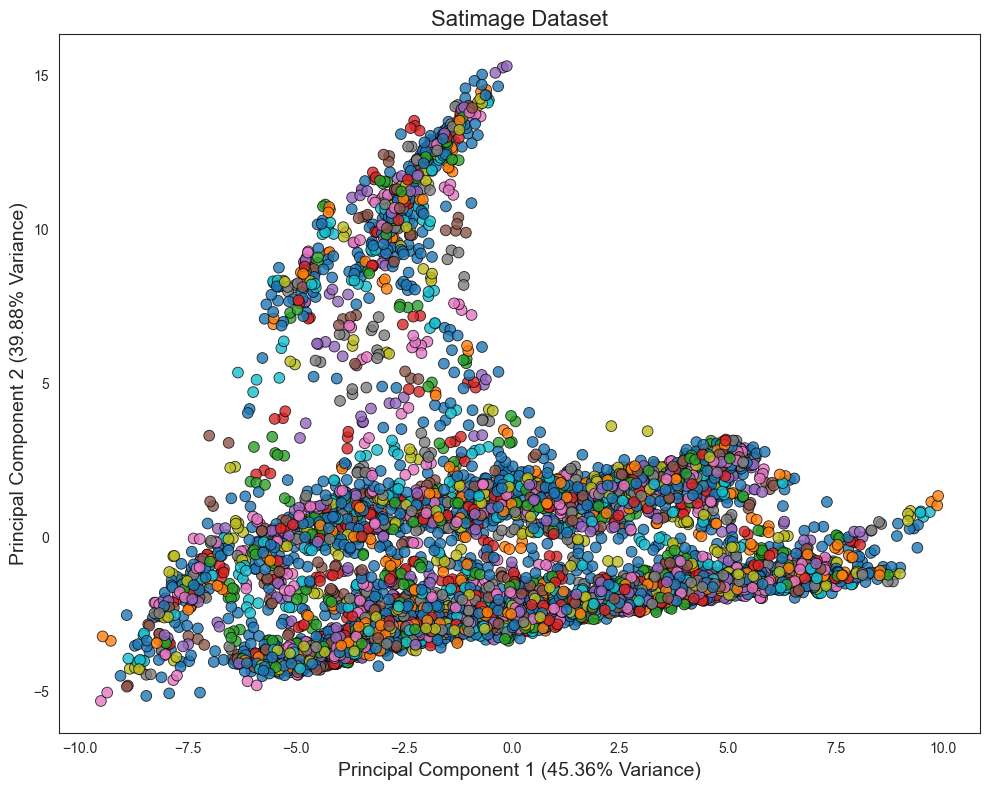

Selected top 133 eigenvectors to reach at least 85.0% (reached 85.17%) cumulative explained variance.

splice took 0.027591943740844727s


/Users/julia/anaconda3/envs/iml/lib/python3.9/site-packages/sklearn/cluster/_optics.py:1083: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


splice got ARI score = 0.16058292720371162


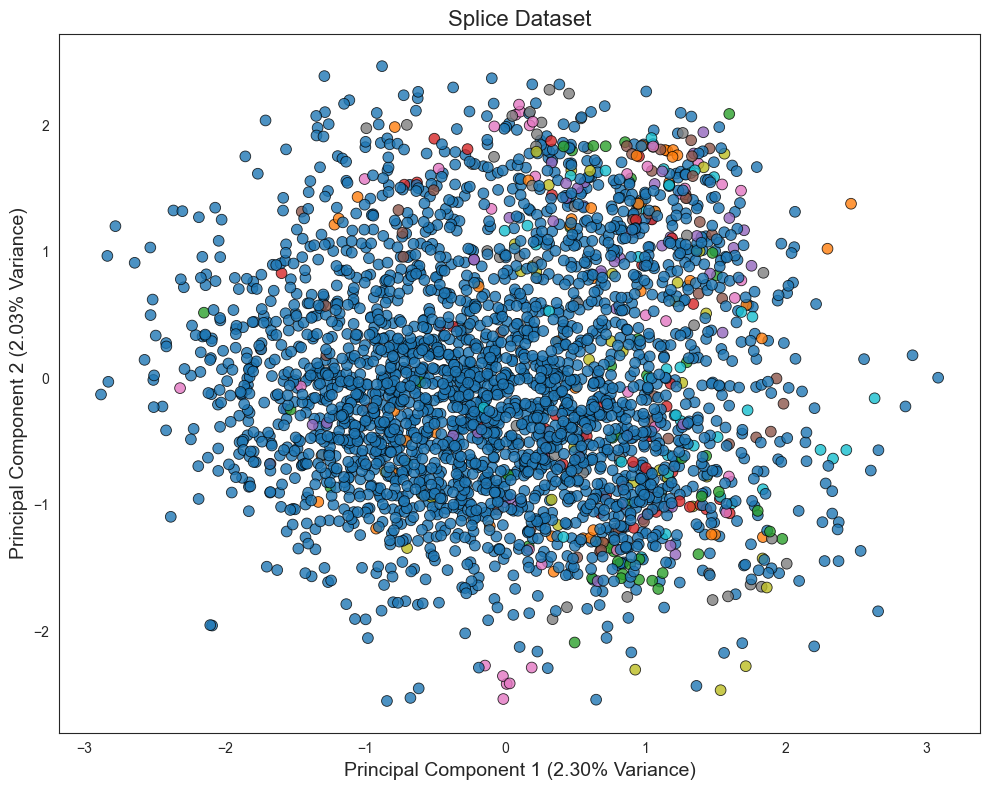

Selected top 8 eigenvectors to reach at least 85.0% (reached 86.00%) cumulative explained variance.

vowel took 0.0045130252838134766s
vowel got ARI score = 0.07383229877487495


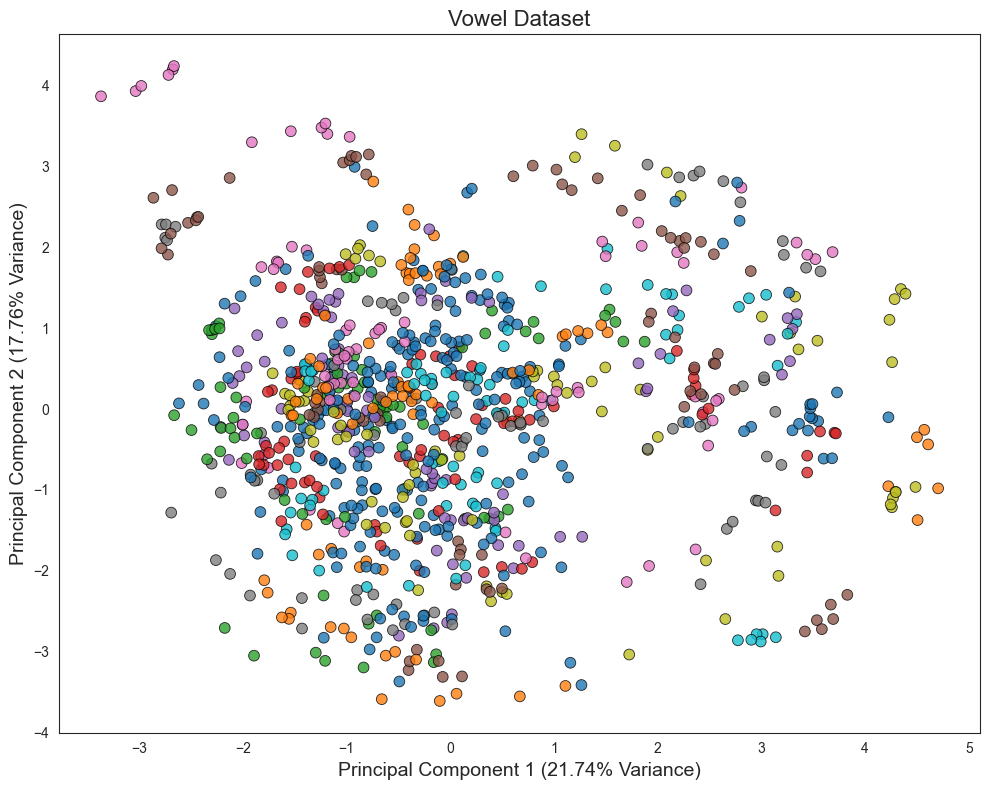

In [18]:
for dataset_name, dataset_content in preprocessed_datasets.items():
    data = dataset_content['df']
    labels = np.array(dataset_content['labels']).astype(int)

    start = time.time()
    reducer = PCA.imlPCA()
    reduced_data = reducer.fit_transform(data)
    end = time.time()
    print(f"{dataset_name} took {end-start}s")

    if dataset_name == 'satimage':
        y_pred = compute_optics(reduced_data, "euclidean", "brute", 2)
    elif dataset_name == 'splice':
        y_pred = compute_optics(reduced_data, "l1", "brute", 2)
    else:
        y_pred = compute_optics(reduced_data, "euclidean", "brute", 4)

    ari_score = adjusted_rand_score(labels, y_pred)
    print(f"{dataset_name} got ARI score = {ari_score}")

    reducer.plot_pca_subspace(reduced_data, y_pred, dataset_name[0].upper()+dataset_name[1:], legend=False)